#Water Segmentation

## Import Libraries

In [43]:
import tifffile as tiff
import matplotlib.pyplot as plt
import os
import numpy as np
import pandas as pd
from PIL import Image
import tensorflow as tf
from tensorflow.keras import Input, regularizers
from keras.layers import Conv2D, Conv2DTranspose, Input, BatchNormalization, Dropout
from keras import regularizers
from sklearn.model_selection import train_test_split
from keras.models import Model,load_model
from glob import glob
# import albumentations as A
from keras.callbacks import EarlyStopping, ReduceLROnPlateau,ModelCheckpoint
from sklearn.metrics import confusion_matrix,classification_report
# import cv2
# from sklearn.metrics import classification_report


In [ ]:
image_height, image_width = 128, 128
batch_size = 16

##Read Data from Google Drive

In [ ]:
!unzip '/content/drive/MyDrive/water_seg_data.zip'

Archive:  /content/drive/MyDrive/water_seg_data.zip
replace data/images/0.tif? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: data/images/0.tif       
  inflating: data/images/1.tif       
  inflating: data/images/10.tif      
  inflating: data/images/100.tif     
  inflating: data/images/101.tif     
  inflating: data/images/102.tif     
  inflating: data/images/103.tif     
  inflating: data/images/104.tif     
  inflating: data/images/105.tif     
  inflating: data/images/106.tif     
  inflating: data/images/107.tif     
  inflating: data/images/108.tif     
  inflating: data/images/109.tif     
  inflating: data/images/11.tif      
  inflating: data/images/110.tif     
  inflating: data/images/111.tif     
  inflating: data/images/112.tif     
  inflating: data/images/113.tif     
  inflating: data/images/114.tif     
  inflating: data/images/115.tif     
  inflating: data/images/116.tif     
  inflating: data/images/117.tif     
  inflating: data/images/118.tif     
  infla

##Preprocessing Data

In [ ]:
# Sorted images and masks
def sort_dataset(folder_path):
    # تحميل مسارات الصور والماسك
    images = sorted(glob(folder_path+'/images/*.tif'))
    labels = sorted(glob(folder_path+'/labels/*.png'))

    # إنشاء إطار بيانات
    dataset = pd.DataFrame({'image_path': images, 'label_path': labels})

    return dataset

In [ ]:
data = sort_dataset('/content/data')
data

,image_path,label_path
0,/content/data/images/0.tif,/content/data/labels/0.png
1,/content/data/images/1.tif,/content/data/labels/1.png
2,/content/data/images/10.tif,/content/data/labels/10.png
3,/content/data/images/100.tif,/content/data/labels/100.png
4,/content/data/images/101.tif,/content/data/labels/101.png
...,...,...
301,/content/data/images/95.tif,/content/data/labels/95.png
302,/content/data/images/96.tif,/content/data/labels/96.png
303,/content/data/images/97.tif,/content/data/labels/97.png
304,/content/data/images/98.tif,/content/data/labels/98.png


In [ ]:


# Function to display image and mask side by side
def display_image_and_mask(image_path, label_path):
    # Use tifffile to open .tif images
    img = tiff.imread(image_path)

    # Check if the image has multiple bands
    if img.ndim > 2:
        # Select the first band for display
        img = img[:,:,0]

    mask = Image.open(label_path)

    # Plot the image and the mask side by side
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))
    axes[0].imshow(img)
    axes[0].set_title('Image')
    axes[0].axis('off')

    axes[1].imshow(mask, cmap='gray')
    axes[1].set_title('Mask')
    axes[1].axis('off')

    plt.show()

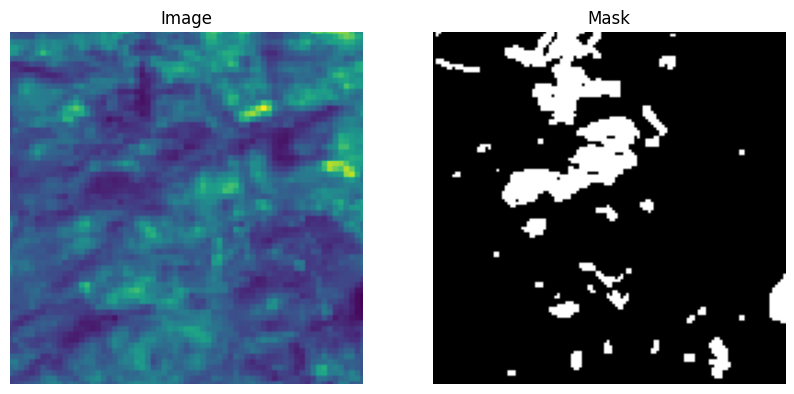

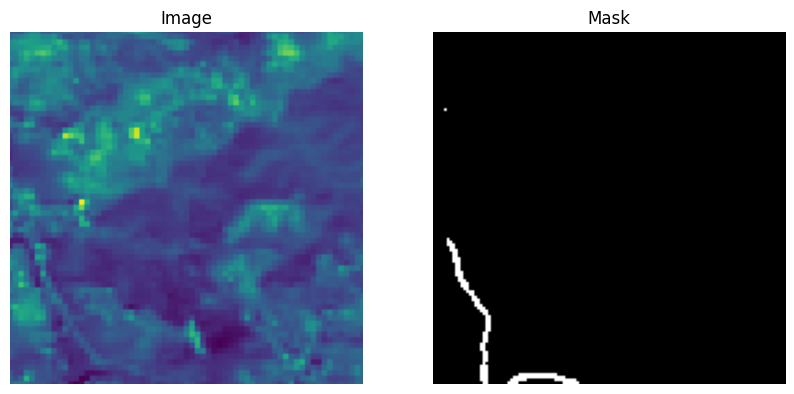

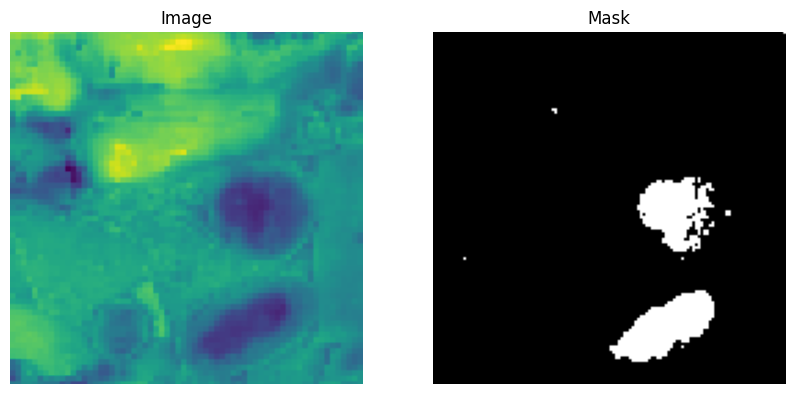

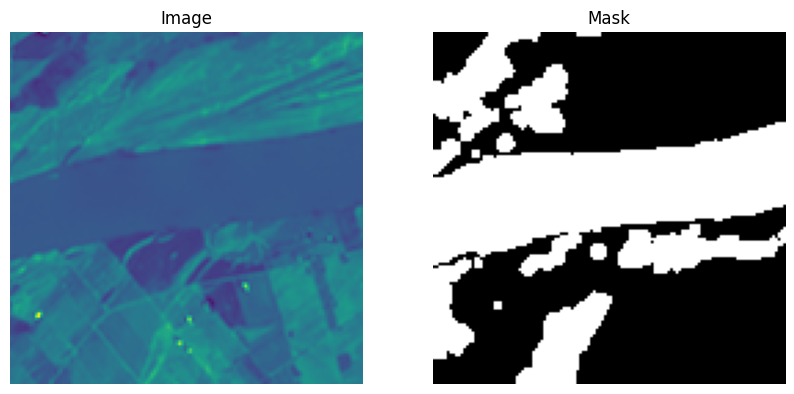

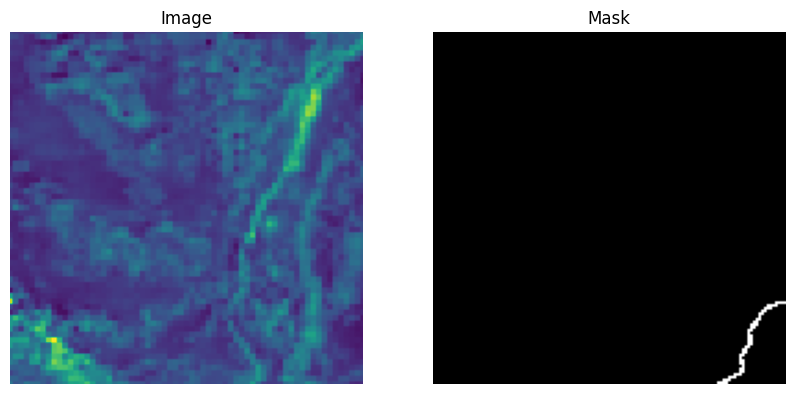

In [ ]:
for img_file, mask_file in zip(data.image_path[:5], data.label_path[:5]):
    # Display the image and mask together
    display_image_and_mask(img_file, mask_file)

In [28]:
def read_images(image_path, label_path, image_height, image_width):
  image = tiff.imread(image_path)
  min_val = np.min(image)
  max_val = np.max(image)
  # تطبيق min-max scaler
  image = (image - min_val) / (max_val - min_val)
  image = tf.convert_to_tensor(image, dtype=tf.float32)
  mask = tf.io.read_file(label_path)
  mask = tf.image.decode_png(mask, channels=1)
  mask = tf.squeeze(mask, axis=-1)
  mask = tf.one_hot(mask, depth=2)
  image = tf.image.resize(image, [image_height, image_width])
  mask = tf.image.resize(mask, [image_height, image_width], method='nearest')
  return image, mask




In [29]:


image_paths = data['image_path'].tolist()  # Convert to a list of file paths
mask_paths = data['label_path'].tolist()
train_images, test_images, train_masks, test_masks = train_test_split(image_paths, mask_paths, test_size=0.15, random_state=42)
train_images, val_images, train_masks, val_masks = train_test_split(train_images, train_masks, test_size=0.2, random_state=42)




def load_dataset(image_paths, mask_paths, image_height, image_width):
    images = []
    masks = []
    for img_path, mask_path in zip(image_paths, mask_paths):
        image, mask = read_images(img_path, mask_path, image_height, image_width)
        images.append(image)
        masks.append(mask)
    return tf.convert_to_tensor(images), tf.convert_to_tensor(masks)

train_images, train_masks = load_dataset(train_images, train_masks, image_height=128, image_width=128)
val_images, val_masks = load_dataset(val_images, val_masks, image_height=128, image_width=128)
test_images, test_masks = load_dataset(test_images, test_masks, image_height=128, image_width=128)


In [30]:
print(f"Train images shape: {train_images.shape}")
print(f"Validation images shape: {val_images.shape}")
print(f"Test images shape: {test_images.shape}")
print(f"Train masks shape: {train_masks.shape}")
print(f"Validation masks shape: {val_masks.shape}")
print(f"Test masks shape: {test_masks.shape}")

Train images shape: (208, 128, 128, 12)
Validation images shape: (52, 128, 128, 12)
Test images shape: (46, 128, 128, 12)
Train masks shape: (208, 128, 128, 2)
Validation masks shape: (52, 128, 128, 2)
Test masks shape: (46, 128, 128, 2)


In [44]:


def MobileNetV2_model(img_height, img_width, img_channels, n_classes):
  # input 12 chanal
  inputs = Input(shape=(img_height, img_width, img_channels))

  # convert 12 to 3 chanal
  reduced_channels = Conv2D(3, (1, 1), padding='same')(inputs)

  base_model = tf.keras.applications.MobileNetV2(
      input_shape=(img_height, img_width, 3),
      include_top=False,
      weights='imagenet'
  )


  base_model.trainable = False
  x = base_model(reduced_channels, training=False)

  x = Conv2D(128, (3, 3), padding='same', activation='relu',
              kernel_regularizer=regularizers.l2(0.00001))(x)
  x = BatchNormalization()(x)
  x = Dropout(0.3)(x)

  x = Conv2DTranspose(128, (3, 3), strides=(2, 2), padding='same')(x)
  x = Dropout(0.3)(x)

  x = Conv2DTranspose(64, (3, 3), strides=(2, 2), padding='same')(x)
  x = Dropout(0.3)(x)

  x = Conv2DTranspose(32, (3, 3), strides=(2, 2), padding='same')(x)
  x = Dropout(0.3)(x)

  x = Conv2DTranspose(16, (3, 3), strides=(2, 2), padding='same')(x)
  x = Dropout(0.3)(x)
  x = Conv2DTranspose(8, (3, 3), strides=(2, 2), padding='same')(x)

  outputs = Conv2D(n_classes, (1, 1), activation='softmax')(x)

  model = Model(inputs=inputs, outputs=outputs)

  return model

model = deeplabv3_reduced_model(
    img_height=128,
    img_width=128,
    img_channels=12,
    n_classes=2
)

model.summary()


Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_13 (InputLayer)          │ (None, 128, 128, 12)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_18 (Conv2D)                   │ (None, 128, 128, 3)         │              39 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ mobilenetv2_1.00_128 (Functional)    │ (None, 4, 4, 1280)          │       2,257,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_19 (Conv2D)                   │ (None, 4, 4, 128)           │       1,474,688 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_5                │ (None, 4, 4, 128)           │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_19 (Dropout)                 │ (None, 4, 4, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_25                  │ (None, 8, 8, 128)           │         147,584 │
│ (Conv2DTranspose)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_20 (Dropout)                 │ (None, 8, 8, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_26                  │ (None, 16, 16, 64)          │          73,792 │
│ (Conv2DTranspose)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_21 (Dropout)                 │ (None, 16, 16, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_27                  │ (None, 32, 32, 32)          │          18,464 │
│ (Conv2DTranspose)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_22 (Dropout)                 │ (None, 32, 32, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_28                  │ (None, 64, 64, 16)          │           4,624 │
│ (Conv2DTranspose)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_29                  │ (None, 128, 128, 8)         │           1,160 │
│ (Conv2DTranspose)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_20 (Conv2D)                   │ (None, 128, 128, 2)         │              18 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,978,865 (15.18 MB)

 Trainable params: 1,720,625 (6.56 MB)

 Non-trainable params: 2,258,240 (8.61 MB)

In [45]:
# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Define callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, min_lr=.00001)
model_checkpoint = ModelCheckpoint('/content/drive/MyDrive/segmentation_model/Deeplab3_segmentation.keras', monitor='val_loss', save_best_only=True)

# Check the shape of your training data
print(f"Train images shape: {train_images.shape}")
print(f"Train masks shape: {train_masks.shape}")


# Train the model using the correct data variables
history = model.fit(
    train_images, train_masks,  # Use train_images and train_masks
    epochs=100,
    validation_data=(val_images, val_masks),  # Use val_images and val_masks
    callbacks=[early_stopping, reduce_lr, model_checkpoint]
)

Train images shape: (208, 128, 128, 12)
Train masks shape: (208, 128, 128, 2)
Epoch 1/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 34s 3s/step - accuracy: 0.5557 - loss: 0.6846 - val_accuracy: 0.8020 - val_loss: 0.5136 - learning_rate: 0.0010
Epoch 2/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 16s 191ms/step - accuracy: 0.7862 - loss: 0.5124 - val_accuracy: 0.8527 - val_loss: 0.4791 - learning_rate: 0.0010
Epoch 3/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 187ms/step - accuracy: 0.8613 - loss: 0.3554 - val_accuracy: 0.8222 - val_loss: 0.4671 - learning_rate: 0.0010
Epoch 4/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.8665 - loss: 0.3177 - val_accuracy: 0.8377 - val_loss: 0.6244 - learning_rate: 0.0010
Epoch 5/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 193ms/step - accuracy: 0.8732 - loss: 0.2986 - val_accuracy: 0.8643 - val_loss: 0.4048 - learning_rate: 0.0010
Epoch 6/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 183ms/step - accuracy: 0.8925 - loss: 0.2584 - val_accuracy: 0.8636 - val_loss: 0.3766 - learning_rate: 0.0010
Epoch 7/100
7/7 ━━

## Load Model

In [46]:
model = load_model('/content/drive/MyDrive/segmentation_model/Deeplab3_segmentation.keras')

In [47]:
test_loss, test_accuracy = model.evaluate(test_images, test_masks, batch_size=32)
print(f'Test Loss: {test_loss}')
print(f'Test Accuracy: {test_accuracy}')

2/2 ━━━━━━━━━━━━━━━━━━━━ 6s 2s/step - accuracy: 0.9258 - loss: 0.1891
Test Loss: 0.1911635547876358
Test Accuracy: 0.9245008230209351


In [48]:

# Get predictions on the test set
predictions = model.predict(test_images)

# Convert predictions to class labels
predicted_labels = np.argmax(predictions, axis=-1)
true_labels = np.argmax(test_masks, axis=-1)

# Flatten the arrays
predicted_labels = predicted_labels.flatten()
true_labels = true_labels.flatten()

report = classification_report(true_labels, predicted_labels)

print(report)

2/2 ━━━━━━━━━━━━━━━━━━━━ 5s 3s/step
              precision    recall  f1-score   support

           0       0.96      0.95      0.95    597417
           1       0.80      0.84      0.82    156247

    accuracy                           0.92    753664
   macro avg       0.88      0.89      0.89    753664
weighted avg       0.93      0.92      0.93    753664



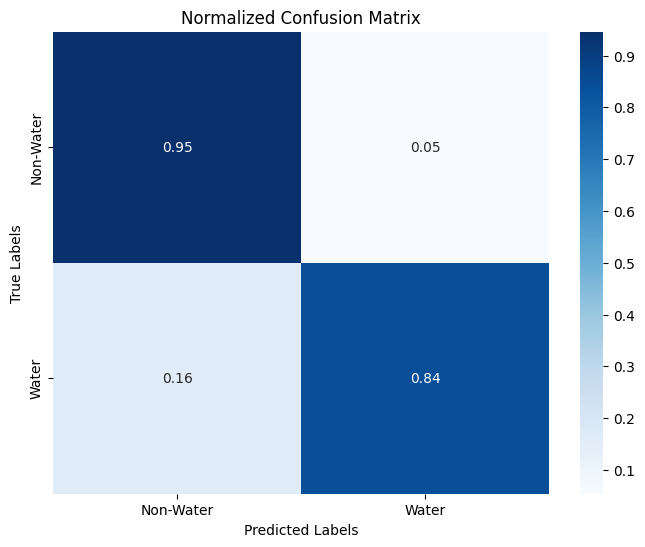

In [49]:
# Calculate the confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)

# Normalize the confusion matrix
cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
import seaborn as sns
# Plot the heatmap with normalized values
plt.figure(figsize=(8, 6))
sns.heatmap(cm_norm, annot=True, fmt=".2f", cmap="Blues", xticklabels=['Non-Water', 'Water'], yticklabels=['Non-Water', 'Water'])
plt.title("Normalized Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()
